<a href="https://colab.research.google.com/github/MisakaTemple/assignment666/blob/main/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import pandas as pd
from sklearn.model_selection import train_test_split
import io

# upload the csv file
uploaded = files.upload()
# get the name of the file
file_name = next(iter(uploaded))
# read the file
data = pd.read_csv(io.BytesIO(uploaded[file_name]))

Saving roma_weather_data.csv to roma_weather_data.csv


In [ ]:
import pandas as pd
from sklearn.model_selection import KFold

# load the data
data = pd.read_csv('roma_weather_data.csv')

# data pre-process
data['DATE'] = pd.to_datetime(data['DATE'], format='%Y%m%d')
data['YEAR'] = data['DATE'].dt.year
data['MONTH'] = data['DATE'].dt.month
data['DAY'] = data['DATE'].dt.day
data['Temp_Range'] = data['ROMA_temp_max'] - data['ROMA_temp_min']

# Calculate the change rates for max temp and min temp
data['Max_Temp_Change_Rate'] = data['ROMA_temp_max'].diff()
data['Min_Temp_Change_Rate'] = data['ROMA_temp_min'].diff()

# delete the NaN
data = data.dropna()


# Select features for test and prediction
features_to_use = ['ROMA_cloud_cover', 'ROMA_humidity', 'ROMA_pressure', 'ROMA_global_radiation', 'ROMA_sunshine','Temp_Range', 'MONTH', 'DAY','Max_Temp_Change_Rate', 'Min_Temp_Change_Rate']
target_feature = 'ROMA_temp_mean'

X = data[features_to_use].values  # X is NumPy list
y = data[target_feature].values   # y is NumPy list

# K-Fold(5)
kf = KFold(n_splits=5, shuffle=True, random_state=42)


In [ ]:
# RNN that not tuned (Take about 5 mins to run and get results)
from keras.layers import Input, SimpleRNN, Dropout, Dense
from keras.models import Model
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import r2_score

num_features = X.shape[1]

# Record the value for every processes
mse_scores = [] # MSE
rmse_scores = [] # RMSE
r2_scores = []  # R^2

# Record prediction and actual
first_fold_pred = None
first_fold_actual = None

for i, (train_index, test_index) in enumerate(kf.split(X)):
    # Segemation
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Standard
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Reshape for RNN
    X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, num_features)
    X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, num_features)

    # Build RNN
    input_layer = Input(shape=(1, num_features))
    rnn_layer1 = SimpleRNN(64,return_sequences=True)(input_layer)
    rnn_layer2 = SimpleRNN(32,return_sequences=True)(rnn_layer1)
    rnn_layer3 = SimpleRNN(16)(rnn_layer2)
    dense_layer = Dense(64, activation='relu')(rnn_layer3)
    dropout_layer = Dropout(0.1)(dense_layer)
    output_layer = Dense(1)(dropout_layer)

    model = Model(inputs=input_layer, outputs=output_layer)

    # Adam and learning rate
    adam = Adam(learning_rate=0.1)
    model.compile(loss='mean_squared_error', optimizer=adam)

    # Train model
    model.fit(X_train_reshaped, y_train, epochs=50, batch_size=16, verbose=0)

    # prediction
    y_pred_rnn = model.predict(X_test_reshaped)

    # For first record
    if i == 0:
        first_fold_pred = y_pred_rnn.flatten()
        first_fold_actual = y_test

    # Calculate MSE and RMSE
    mse = mean_squared_error(y_test, y_pred_rnn)
    rmse = np.sqrt(mse)
    # Calculate R^2
    r2 = r2_score(y_test, y_pred_rnn)

    # Put value into list
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

# Average
average_mse = np.mean(mse_scores)
average_rmse = np.mean(rmse_scores)
average_r2 = np.mean(r2_scores)
# Output result
print(f'Average Mean Squared Error: {average_mse}')
print(f'Average Root Mean Squared Error: {average_rmse}')
print(f'Average R^2: {average_r2}')



23/23 [==============================] - 0s 2ms/step
Average Mean Squared Error: 15.95811214740426
Average Root Mean Squared Error: 3.988934254763199
Average R^2: 0.6684156590355007


In [ ]:
# Tuned RNN (Take about 10-15 mins to run and get results)
from keras.layers import Input, SimpleRNN, Dropout, Dense
from keras.models import Model
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import r2_score

num_features = X.shape[1]

# Record the value for every processes
mse_scores = [] # MSE
rmse_scores = [] # RMSE
r2_scores = []  # R^2

# Record prediction and actual
first_fold_pred_new = None
first_fold_actual_new = None

for i, (train_index, test_index) in enumerate(kf.split(X)):
    # Segemation
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Standard
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Reshape for RNN
    X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, num_features)
    X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, num_features)

    # Build RNN
    input_layer = Input(shape=(1, num_features))
    rnn_layer1 = SimpleRNN(256, activation='tanh', return_sequences=True)(input_layer)
    rnn_layer2 = SimpleRNN(128, activation='tanh', return_sequences=True)(rnn_layer1)
    rnn_layer3 = SimpleRNN(64, activation='tanh')(rnn_layer2)
    dense_layer = Dense(64, activation='relu')(rnn_layer3)
    dropout_layer = Dropout(0.5)(dense_layer)
    output_layer = Dense(1)(dropout_layer)

    model = Model(inputs=input_layer, outputs=output_layer)

    # Adam and learning rate
    adam = Adam(learning_rate=0.0001)
    model.compile(loss='mean_squared_error', optimizer=adam)

    # Train model
    model.fit(X_train_reshaped, y_train, epochs=100, batch_size=16, verbose=0)

    # prediction
    y_pred_rnn = model.predict(X_test_reshaped)

    # For first record
    if i == 0:
        first_fold_pred_new = y_pred_rnn.flatten()
        first_fold_actual_new = y_test

    # Calculate MSE and RMSE
    mse = mean_squared_error(y_test, y_pred_rnn)
    rmse = np.sqrt(mse)
    # Calculate R^2
    r2 = r2_score(y_test, y_pred_rnn)

    # Put value into list
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

# Average
average_mse = np.mean(mse_scores)
average_rmse = np.mean(rmse_scores)
average_r2 = np.mean(r2_scores)
# Output result
print(f'Average Mean Squared Error: {average_mse}')
print(f'Average Root Mean Squared Error: {average_rmse}')
print(f'Average R^2: {average_r2}')


23/23 [==============================] - 1s 5ms/step
Average Mean Squared Error: 4.814886684276476
Average Root Mean Squared Error: 2.193507062775497
Average R^2: 0.8997296282632963


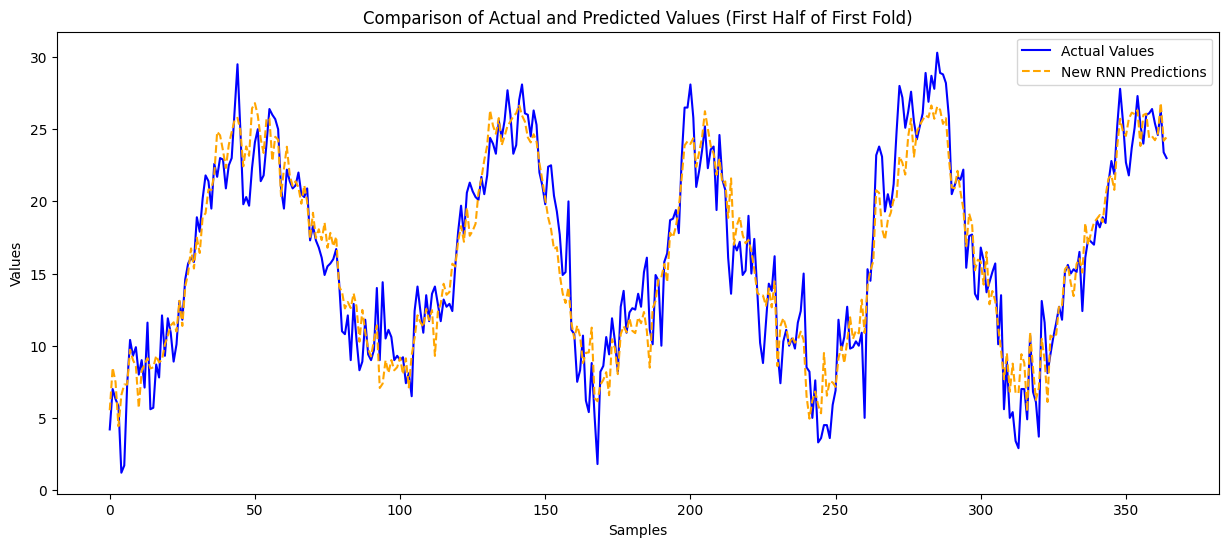

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Show the length of graph（50%）
half_length = len(first_fold_actual) // 2

# visualization
plt.figure(figsize=(15, 6))
# Actual
plt.plot(first_fold_actual[:half_length], label='Actual Values', color='blue')
# Not tuned
plt.plot(first_fold_pred[:half_length], label='RNN Predictions', color='green', linestyle='dashed')
# Tuned
plt.plot(first_fold_pred_new[:half_length], label='New RNN Predictions', color='orange', linestyle='dashed')
# Info
plt.title('Comparison of Actual and Predicted Values (First Half of First Fold)')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()
plt.show()
